Questions to answer by this EDA:
- What kind of data do we have? 
    - What kind of data do we have. Numeric, images, time series?  
    - How big is the dataset?   \[x]
    - Can we use classic motion models to provide extra information?
- How does l5kit work?
    - Can we combine zarr files?
    - other functionality that might prove useful
    - What information does the rasterizer encode and what does it miss? Does it encode agent type?
- General visualization and analysis
    - How is the data distributed?
    - Is the data complete?
    - Does the data need any cleaning?

In [2]:
import numpy as np
import pandas
import l5kit

from l5kit.data import ChunkedDataset, LocalDataManager
from l5kit.dataset import EgoDataset, AgentDataset

from l5kit.rasterization import build_rasterizer
from l5kit.configs import load_config_data
from l5kit.visualization import draw_trajectory, TARGET_POINTS_COLOR, REFERENCE_TRAJ_COLOR 
from l5kit.geometry import transform_points
from tqdm import tqdm
from collections import Counter
from l5kit.data import PERCEPTION_LABELS
from prettytable import PrettyTable
import matplotlib.pyplot as plt

In [14]:
os.environ["L5KIT_DATA_FOLDER"] = "/home/elias/Documents/lyft-motion-prediction/data"

cfg = load_config_data("./eda_config.yaml")

print(f'current raster_param:\n')
for k,v in cfg["raster_params"].items():
    print(f"{k}:{v}")


current raster_param:

raster_size:[224, 224]
pixel_size:[0.5, 0.5]
ego_center:[0.25, 0.5]
map_type:py_semantic
satellite_map_key:aerial_map/aerial_map.png
semantic_map_key:semantic_map/semantic_map.pb
dataset_meta_key:meta.json
filter_agents_threshold:0.5
disable_traffic_light_faces:False


# Loading the data

In [15]:
dm = LocalDataManager()
sample_dataset_path = dm.require(cfg["sample_data_loader"]["key"])
train_dataset_path = dm.require(cfg["train_data_loader"]["key"])
validate_dataset_path = dm.require(cfg["val_data_loader"]["key"])

sample_dataset = ChunkedDataset(sample_dataset_path)
train_dataset = ChunkedDataset(train_dataset_path)
validate_dataset = ChunkedDataset(validate_dataset_path)

print("SAMPLE DATASET")
sample_dataset.open()
print(sample_dataset)

print("TRAINING DATASET")
train_dataset.open()
print(train_dataset)

print("VALIDATION DATASET")
validate_dataset.open()
print(validate_dataset)

SAMPLE DATASET
+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+
| Num Scenes | Num Frames | Num Agents | Num TR lights | Total Time (hr) | Avg Frames per Scene | Avg Agents per Frame | Avg Scene Time (sec) | Avg Frame frequency |
+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+
|    100     |   24838    |  1893736   |     316008    |       0.69      |        248.38        |        76.24         |        24.83         |        10.00        |
+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+
TRAINING DATASET
+------------+------------+------------+---------------+-----------------+----------------------+----------------------+------------------

The validation dataset seems to be just as large as the training dataset. For training of the final model, this data should definately be included in training

# What kind of data do we have?

In this data, l5kit provides four structured arrays that contain data. These are Scenes, frames, agents and traffic light faces.

## Scenes

First we look at scenes. A scene is identified by the ego vehicle who collected the data, as well as a start and end time. It thus consists of many frames that make up that scene. The start and end inded of these frames are stored in the scene datatype.

In [3]:
SCENE_DTYPE = [
    ("frame_index_interval", np.int64, (2,)),
    ("host", "<U16"),  # Unicode string up to 16 chars
    ("start_time", np.int64),
    ("end_time", np.int64),
]

## Frames
Next we have frame. A frame captures all the information observed at the specific time. This includes:
- Timestap
- data about the ego vehicle (rotation and position)
- Reference to other agents captured by the sensors (a pointer)
- Reference to all traffic light faces in the visible lanes


In [ ]:
FRAME_DTYPE = [
    ("timestamp", np.int64),
    ("agent_index_interval", np.int64, (2,)),
    ("traffic_light_faces_index_interval", np.int64, (2,)),
    ("ego_translation", np.float64, (3,)),
    ("ego_rotation", np.float64, (3, 3)),
]

## Agents

An agent is an observed object that was detected by the ego vehicle. each agent object contains information such as position, velocity, and a tracking number to keep track of it over multiple frames (within one scene). The most probable label is also included. This label should be important information to give the neural network, as a car, pedestrian, and bicyclist will behave quite differently in the traffic.  

In [ ]:
AGENT_DTYPE = [
    ("centroid", np.float64, (2,)),
    ("extent", np.float32, (3,)),
    ("yaw", np.float32),
    ("velocity", np.float32, (2,)),
    ("track_id", np.uint64),
    ("label_probabilities", np.float32, (len(LABELS),)),
]

## Traffic Light Faces

The semantic map only holds static information about the world. So it has a list of all traffic lights, but not their current status. This type of information is stored in this traffic light face object. if status >0, it is active. NOTE: a traffic light face is a specific light bulb, like the red light bulb of a specific traffic light.

In [ ]:
TL_FACE_DTYPE = [
    ("face_id", "<U16"),
    ("traffic_light_id", "<U16"),
    ("traffic_light_face_status", np.float32, (len(TL_FACE_LABELS,))),
]

In [18]:
# Rasterizer
rast = build_rasterizer(cfg, dm)

# Dataset
dataset = EgoDataset(cfg, train_dataset, rast)

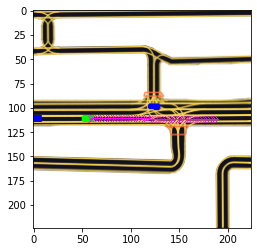

[[2.00000000e+00 7.58220079e-17 5.60000000e+01]
 [8.43052207e-17 2.00000000e+00 1.12000000e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]


In [47]:
data = dataset[250]
im = data["image"].transpose(1, 2, 0)
im = dataset.rasterizer.to_rgb(im)
target_positions_pixels = transform_points(data["target_positions"], data["raster_from_agent"])


draw_trajectory(im, target_positions_pixels, TARGET_POINTS_COLOR, yaws=data["target_yaws"])


plt.imshow(im[::-1])
plt.show()

data.keys()
print(data["raster_from_agent"])